/opt/anaconda3/envs/GXG_GNNShap/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


here
get_all_kinds_of_gate
所有网表： 13 ['RS232-T1000.v', 'RS232-T1100.v', 'RS232-T1200.v', 'RS232-T1300.v', 'RS232-T1400.v', 'RS232-T1500.v', 'RS232-T1600.v', 's38417-T100.v', 's38417-T200.v', 's38417-T300.v', 's35932-T100.v', 's35932-T200.v', 's35932-T300.v'] 
所有的门节点种类: 64 {'SDFFSRX1', 'NAND4X1', 'OAI22X1', 'SDFFX1', 'OR3X1', 'OAI21X1', 'DFFX2', 'NOR2X4', 'OA22X1', 'NBUFFX2', 'NAND3X4', 'DFFARX1', 'NAND3X1', 'DFFASX1', 'AO221X1', 'MUX21X1', 'OAI21X2', 'NOR4X0', 'LSDNENX1', 'AND2X1', 'XNOR2X1', 'NAND2X1', 'AO21X1', 'NAND3X0', 'OA21X1', 'AO222X1', 'AOI22X1', 'AND4X1', 'INVX8', 'AOI21X2', 'NOR3X1', 'AND3X1', 'OA222X1', 'AOI221X1', 'AOI21X1', 'NOR3X0', 'XNOR3X1', 'NOR4X1', 'NAND2X0', 'INVX0', 'MUX21X2', 'AOI22X2', 'INVX32', 'AOI222X1', 'NOR2X0', 'XOR2X2', 'OA221X1', 'NAND4X0', 'OAI221X1', 'OR4X1', 'NBUFFX16', 'AND3X4', 'AO22X1', 'XOR3X1', 'OR4X4', 'ISOLANDX1', 'LSDNX1', 'XOR2X1', 'OR2X1', 'NOR2X2', 'OAI222X1', 'ISOLORX8', 'NAND2X4', 'AND2X4'}
------------当前网表文件为：RS232-T1000.v---------- （1）输出

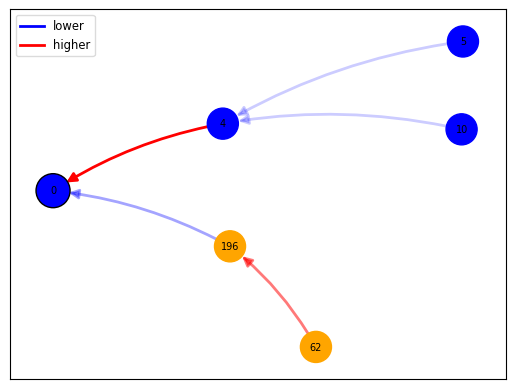

AttributeError: 'GNNShapExplanation' object has no attribute 'node_feat_imp'

In [1]:
import Gxg_process_lib
import networkx as nx
import torch
import torch.nn.functional as F
import re
import Function
import time
import os
import numpy as np

from sklearn.metrics import roc_curve
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut



import sys
sys.path.append('/home/adhoc/GXG/GNNShap/GNNShap')
from gnnshap.explainer import GNNShapExplainer





# relapath = '/3lun_attack/Tfangyu/'
relapath = '/allsandRS/'

files = \
    [
        'RS232-T1000.v',
        'RS232-T1100.v', 'RS232-T1200.v', 'RS232-T1300.v',
        'RS232-T1400.v', 'RS232-T1500.v', 'RS232-T1600.v',
        # 原13个基础上再加如下：
        # 'RS232-T1700.v', 'RS232-T1800.v', 'RS232-T1900.v', 'RS232-T2000.v',

        's38417-T100.v', 's38417-T200.v', 's38417-T300.v',
        's35932-T100.v', 's35932-T200.v', 's35932-T300.v',
        # 原13个基础上再加如下：
        # 's38584-T100.v', 's15850-T100.v'  # s38584-T200和T300 ?

    ]

#  special_files里的木马节点标签是按名称类别打的，比如 dicTrojan['s38584-T100.v'] = ['Trojan', 'NOT_test_se'] # 9
#     dicTrojan['s15850-T100.v'] = ['Trojan', 'INVtest_se', 'Tg'] # 15
#     dicTrojan['s38417-T100.v'] = ['Trojan'] # 12,15,15


dicTrojan = Function.dicTrojan


#  现在是19个网表里的69个类型
# global_node_types = ['NBUFFX16', 'AND2X1', 'DFFASX1', 'SDFFSRX1', 'XOR2X2', 'ISOLORX8', 'AO222X1', 'NOR3X0', 'INVX8',
#                      'NBUFFX2', 'AOI21X1', 'OA22X1', 'OAI22X1', 'OAI21X2', 'NAND4X0', 'AOI222X1', 'OAI222X1', 'NOR3X1',
#                      'AND2X4', 'NAND4X1', 'OR3X1', 'AOI22X2', 'OAI21X1', 'XOR3X1', 'NAND2X1', 'NOR2X0', 'OAI221X1',
#                      'INV1X1', 'AND4X1', 'OR2X1', 'OR4X1', 'AOI21X2', 'NAND3X1', 'INVX32', 'AOI221X1', 'XNOR3X1',
#                      'NOR4X1', 'AO21X1', 'NAND2X0', 'AO221X1', 'NOR2X4', 'LSDNX1', 'XNOR2X1', 'DFFX2', 'OR4X4',
#                      'OA21X1', 'AND3X1', 'SDFFX1', 'NAND3X0', 'LSDNENX1', 'DFFARX1', 'INVX0', 'NAND3X4', 'MUX21X2',
#                      'NOR4X0', 'ISOLANDX1', 'AO22X1', 'XOR2X1', 'NOR2X2', 'NAND2X4', 'MUX21X1', 'OA221X1', 'OA222X1',
#                      'AOI22X1']

# global_types2idx = {v: k for k, v in enumerate(global_node_types)}
# num_feature_dim = len(global_node_types)


# class GCN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, hidden_channels2, out_channels):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels2)
#         self.conv3 = GCNConv(hidden_channels2, out_channels)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         # First Graph Convolution Layer
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)

#         # Second Graph Convolution Layer
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)

#         # Third Graph Convolution Layer
#         x = self.conv3(x, edge_index)

#         # Apply log softmax to the output
#         return F.log_softmax(x, dim=1)






class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, hidden_channels2, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        # 检查 edge_weight，如果为空则使用默认值
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)
























# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(num_feature_dim, 16)
#         self.conv2 = GCNConv(16, 2)
#
#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#
#         return F.log_softmax(x, dim=1)


# 对节点特征进行处理转换
def normalize(nx_graph, netlist_name, all_tj):
    in_degrees = [val for (node, val) in nx_graph.in_degree()]
    out_degrees = [val for (node, val) in nx_graph.out_degree()]
    special_files = ['s38417-T100.v', 's38417-T200.v', 's38417-T300.v',
                     's35932-T100.v', 's35932-T200.v', 's35932-T300.v',
                     's38584-T100.v', 's15850-T100.v',

                     'c2670-T000.v', 'c2670-T050.v', 'c3540-T000.v', 'c3540-T050.v',
                     'c5315-T000.v', 'c5315-T050.v', 'c6288-T000.v', 'c6288-T050.v',
                     's1423-T000.v', 's1423-T200.v', 's13207-T000.v', 's13207-T200.v',
                     's15850-T000.v', 's15850-T200.v', 's35932-T000.v', 's35932-T200.v',

                     's1423-T400.v', 's1423-T600.v', 's13207-T400.v', 's13207-T600.v',
                     's15850-T400.v', 's15850-T600.v', 's35932-T400.v', 's35932-T600.v']
    net_tj = []
    for idx, node in enumerate(nx_graph.nodes(data=True)):

        nodetype = node[1]['label'][0]
        # 第一个if先判断是否是s系列等网表，如果是，则特殊处理，因为s系列的dicTrojan木马节点列表不是一一对应节点名称的
        #  注意：这里normalize打标签方式与其他脚本都不尽相同，需要随数据集修改
        if netlist_name in special_files:
            for typename in dicTrojan[netlist_name]:
                # print(type(typename), netlist_name, dicTrojan[netlist_name], type(node[0]))
                if typename in node[0]:
                    net_tj.append(node[0])
                    node[1]['y'] = 1
                    break
                node[1]['y'] = 0
        else:
            if node[0] in dicTrojan[netlist_name]:
                net_tj.append(node[0])
                node[1]['y'] = 1
            else:
                node[1]['y'] = 0
        # if in_degrees[idx] == 0:
        #     type_of_node = "output"
        # elif out_degrees[idx] == 0:
        #     type_of_node = "input"
        # else:
        #     type_of_node = nodetype

        type_of_node = nodetype

        if type_of_node not in global_node_types:
            print("----------" + type_of_node + "-------------")
            raise Exception(
                "type_of_node not in global_node_types!!!")

        node[1]['x'] = global_types2idx[type_of_node]

    tjnet = {netlist_name: net_tj}
    all_tj.append(tjnet)


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    # 返回数据集源文件名
    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    # 返回process方法所需的保存文件名。你之后保存的数据集名字和列表里的一致
    @property
    def processed_file_names(self):
        return ['data.pt']

        # #用于从网上下载数据集---这里注释掉
        # def download(self):
        #     # Download to `self.raw_dir`.
        #     download_url(url, self.raw_dir)
        ...

    # 生成数据集所用的方法
    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


#  字典中由值查找键
def get_key(dict, value):
    return [k for k, v in dict.items() if v == value]


def infoExtracion(path, outpath, printornot):
    '''
    传入参数阐述：
    :param path: 待提取的网表文件路径
    :return:
    '''
    index = 0
    for i in range(len(path) - 1, 0, -1):
        if path[i] == '/' or path[i] == '\\':
            index = i
            break
    filename = path[index + 1:]
    outfile = outpath + filename

    # 定义参数
    Input = []  # 存储主输入信号：input
    Output = []  # 存储主输出信号：output
    width = {}  # 存储信号宽度
    dicofAssign = {}  # 存储assign赋值相关信息
    gate = []  # 存储所有例化语句的逻辑门名字
    gate_info = {}  # 存储例化语句。key为例化名，value为逻辑器件，器件类型，入度，出度，输入信号常数个数，输入端口列表，输出端口列表
    # 如，dic['gateA'] = ['AND4X1', 'AND', 3, 2, 0, ['in1'], ['out1','out2']]
    edge = {}  # 存边的信息，key为边，value为[head,tail]，其中head唯一，但tail不一定唯一
    headTotail = {}  # key为逻辑器件，value为列表，与key直连的逻辑器件
    tailTohead = {}

    t1 = time.time()

    # print('--当前网表文件为：%s' % (filename))

    fp = open(path, 'r')
    content = fp.read()
    data = content.split(';')
    # print(",,,,,,,,,,,,,,",data,type(data))

    '''---------------步骤1----------------
            读取代码文件中每行语句，去除注释行，将相应信号和逻辑信息存储；
    '''

    flagOfassign = 1
    for item in data:  # 检查每一条用；分开的语句
        item = item.strip()

        if 1:
            # 注释行//，直接去掉
            if re.search('\/\/', item.strip()):
                item1 = item.split('\n')
                str1 = ''
                for item2 in item1:
                    if re.search('\/\/', item2.strip()) is None:
                        str1 = str1 + item2.strip() + ' '
                item = str1

            if re.search('\/\*', item.strip()):
                item1 = item.split('\n')
                str1 = ''
                for item2 in item1:
                    if re.search('\/\*', item2.strip()) is None:
                        str1 = str1 + item2.strip() + ' '
                item = str1

            # 多行，直接合并为一行
            if re.search('\n', item.strip()):
                tmp = item.split('\n')
                str1 = ''
                for item1 in tmp:
                    str1 = str1 + item1.strip() + ' '
                item = str1

            # 空行
            if item.strip() == '':
                continue
            else:
                item = item.strip()

        if item[:7] == 'module ' or item == 'endmodule':
            # print('开始/结束读入')
            continue

        elif item[:6] == 'input ':
            inputList = []
            if re.search(',', item) is not None:
                inputList = item[6:].split(',')
            else:
                inputList.append(item[6:])

            for item1 in inputList:
                if re.search('\[', item1) is not None:
                    index = item1.find(']')
                    Input.append(item1[index + 2:].strip())
                    width[item1[index + 2:].strip()] = Function.calWidth(item1[:index])  # 记录信号宽度
                else:
                    Input.append(item1.strip())

        elif item[:7] == 'output ':
            outputList = []
            if re.search(',', item) is not None:
                outputList = item[7:].split(',')
            else:
                outputList.append(item[7:])
            for item1 in outputList:
                if re.search('\[', item1) is not None:
                    index = item1.find(']')
                    Output.append(item1[index + 2:].strip())
                    width[item1[index + 2:].strip()] = Function.calWidth(item1[:index])
                else:
                    Output.append(item1.strip())

        elif item[:5] == 'wire ':
            wireList = []
            if re.search(',', item) is not None:
                wireList = item[5:].split(',')
            else:
                wireList.append(item[5:])

            for item1 in wireList:
                if re.search('\[', item1) is not None:
                    index = item1.find(']')
                    wid = Function.calWidth(item1[:index])
                    if item1[index + 1:].strip() == 'FP':
                        print('当前宽度：', wid)
                    if wid > 1:
                        width[item1[index + 1:].strip()] = wid

        elif item[:7] == 'assign ':
            item = item[7:].strip()
            tmp = item.split('=')
            left = Function.SplitofAssign(tmp[0].strip(), width)
            right = Function.SplitofAssign(tmp[1].strip(), width)

            if len(left) != len(right):
                print('当前assign项左右数量不同：', item)
                print(len(left), len(right))
                print('                    ：', left)
                print('                    ：', right)
                exit()

            for item1, item2 in zip(left, right):
                if item1 in dicofAssign.keys():
                    print('当前assign项已经出现过，左边已经被赋值过一次（发生错误）：', item)
                    exit()
                else:
                    if re.search('\'', item2) is None:  # 不是常数赋值
                        dicofAssign[item1] = item2
                    else:  # 是常数赋值
                        # print('出现常数赋值，进行记录', item)
                        dicofAssign[item1] = item2

        else:  # 说明是例化语句，开始分析和切割gatename, type和端口列表等
            # print(item)
            if flagOfassign == 1:
                # print('执行assign多重搜索：')
                for key, value in dicofAssign.items():
                    if value in dicofAssign.keys():
                        value1 = value
                        while 1:
                            dicofAssign[key] = dicofAssign[value1]
                            value1 = dicofAssign[key]
                            # print('当前assign赋值是多重赋值：', key)
                            # print('      ', key, dicofAssign[key])
                            if dicofAssign[key] in dicofAssign.keys():
                                continue
                            else:
                                break
                    else:
                        pass
                flagOfassign = 0

            if len(item.split(' ')) < 3:
                print('当前例化语句分割有误，不能分割开名字、类型和端口：', item)
                exit()
            else:  # 此时的例化语句一定能合理划分
                index = 0
                for i1 in range(len(item)):
                    if item[i1] != ' ':
                        index += 1
                    else:
                        break
                gatetype = item[:index].strip()
                for i1 in range(index + 1, len(item)):
                    if item[i1] != ' ':
                        index = i1
                        break
                gatename = item[index:].split(' ')[0]
                # print('输出例化名：', gatetype, gatename)

                if gatename in gate:
                    print('当前例化模块重名，已出现过：', item)
                    exit()

                gate.append(gatename)
                gate_info[gatename] = []
                gate_info[gatename].append(gatetype)  # 添加gate的type进字典
                if re.search('DFF', gatetype) or re.search('dff', gatetype):
                    gate_info[gatename].append('DFF')
                elif re.search('INV', gatetype) or re.search('hi', gatetype) or re.search('nb', gatetype) or re.search(
                        'i1', gatetype) or re.search('ib', gatetype):
                    gate_info[gatename].append('INV')
                elif re.search('MUX', gatetype) or re.search('mx', gatetype):
                    gate_info[gatename].append('MUX')
                else:
                    gate_info[gatename].append('')

                # 添加gate的输入端口列表和输出端口列表
                inedge = []
                outedge = []
                index = item.find('(')
                tmp = item[index + 1:-1].strip()
                portlist = tmp.split(',')  # 例化模块的端口列表

                len1 = 0
                len2 = 0
                len3 = 0
                for port in portlist:  # 大括号括起来的多变量，常数，
                    if re.search('\.O', port) is not None or re.search('\.Q', port) or re.search('\.QN',
                                                                                                 port) or re.search(
                        '\.Y', port):
                        # print('输出端口：', port)
                        len2 += 1
                        edgetmp = Function.EdgeList(port.strip())
                        if edgetmp != '':
                            outedge.append(edgetmp)
                    else:
                        # print('输入端口：', port)
                        len1 += 1
                        edgetmp = Function.EdgeList(port.strip())
                        if edgetmp != '' and re.search('\'b', edgetmp) is None:
                            len3 += 1
                            inedge.append(edgetmp)

                gate_info[gatename].append(len1)
                gate_info[gatename].append(len2)
                gate_info[gatename].append(0)  # 输入端口常数个数
                flagOfconst = 0
                if len3 < len1:
                    gate_info[gatename][4] = len1 - len3
                    # print('11111当前端口有常数输入：', gatename, end=' ')  # 可去掉
                    # print('11111个数为：', gate_info[gatename][4], gate_info[gatename], item) # 可去掉
                    flagOfconst = 1
                for e1 in inedge:
                    if e1 in dicofAssign.keys() and re.search('\'', dicofAssign[e1]) is not None:  # 若当前边是个常数，就改变端口常数个数
                        gate_info[gatename][4] += 1
                        flagOfconst = 1
                        # print('22222对当前端口的常数个数进行更新：', item) # 可去掉
                        # print('22222其对应的赋值语句为：', e1, dicofAssign[e1] ) # 可去掉
                        # print('个数为：', gate_info[gatename][4], gate_info[gatename], item)
                if flagOfconst == 1:
                    pass
                    # print('当前端口有常数输入：')  # 可去掉
                    # print(gate_info[gatename][4], gate_info[gatename], item) # 可去掉

                gate_info[gatename].append(inedge)
                gate_info[gatename].append(outedge)
                if len1 == 0 or len2 == 0:
                    print('33333当前例化模块无输入或者输出', item)
                    exit()  # 检测是否有新的输入输出标识，不能去掉

                # 一条edge只能从一个地方出来，却能去很多个地方
                for e1 in inedge:
                    if e1 not in edge.keys():
                        edge[e1] = []
                    edge[e1].append(['NULL', gatename])
    #    65行开始的for item in data:  # 检查每一条用；分开的语句 在这里结束

    if 1:
        for key, value in dicofAssign.items():  # 加入输出和输出信号，弥补assign的连接
            if value in Input:
                Input.append(key)

            if key in Input:
                if re.search('\'', value) is not None:
                    pass
                    # print('常数赋给了输入：', key, value)

            if value in Output and key not in Output:
                Output.append(key)
                # print('Output赋给了别的信号：', key, value)

            if key in Output and value not in Output:
                if re.search('\'', value) is not None:
                    pass
                    # print('常数赋给了输出：', key, value)
                else:
                    Output.append(value)
                    # print('某个信号赋给了Output：', key, value)

    for name in gate:  # 给所有的边添加弧头
        outlist = gate_info[name][-1]
        for out in outlist:
            if out in edge.keys():
                for tmp in edge[out]:
                    if tmp[0] == 'NULL':
                        tmp[0] = name
                    else:
                        print('44444当前边已经被添加了弧头，一条边从两个地方出来：', name, out)
                        exit()
            else:  # 当前边未被存储，说明弧尾没有器件
                #
                if out not in Output:
                    pass
                    # print('55555当前边没有存储，说明当前边是最终输出。该器件是：', name, '该边为：', out)
                    # print('      但该边不是输出')
                # exit() # 最后删掉，只剩pass
                # pass

    for key, value in dicofAssign.items():
        # 完善电路连接
        # 可能是：value为空（输入信号被连或者无用线）；
        #        key为空（输出信号赋值或者无用线）

        # 情况1：value可能为空，说明前面没连信号
        # 一般input信号赋给了别的信号参与电路，自己可能不直接连
        if value not in edge.keys():
            continue

        # 情况2：key可能为空，说明被赋值信号不连接电路
        # 当某变量赋给了output，自己再去参与电路，该output信号就输出
        if key not in edge.keys():
            continue

        # 此时key和value都不为空
        l1 = edge[key]
        l2 = edge[value]

        # 剩continue，不要判断语句
        # 情况3：无贡献的赋值边
        if l2[0][0] == 'NULL':
            # continue
            if value in Input:  # 成品去掉if-else，剩continue
                print('66666该赋值边是输入信号，并且没有连器件：', key, value)
            else:
                print('77777该赋值边为空，是无用的wire：', key, value)
                exit()

        # 情况4：有贡献的赋值边
        for i1 in range(len(l1)):
            if l1[i1][0] != 'NULL':  # 这个if成品去掉
                print('88888该被赋值边已经连了输出器件，发生错误：', key, value)
                exit()
            else:
                l1[i1][0] = l2[0][0]
        edge[key] = l1

    if printornot:
        print('------------当前网表文件为：%s----------' % filename, '（1）输出Input:', len(Input), '（2）输出output',
              len(Output), '（6）输出逻辑门信息gate_info：', len(gate_info))

        # print('（3）信号位宽数据个数：', len(width))
        # for key, value in width.items():
        #     print('{key}：{value}'.format(key=key, value=value))
        # print('（4）assign赋值项个数：', len(dicofAssign))
        # for key, value in dicofAssign.items():
        #     print('{key}：{value}'.format(key=key, value=value))
        # print('（5）例化语句逻辑门个数：', len(gate))
        # print()

        # for key, value in gate_info.items():
        #     print('{key}：{value}'.format(key=key, value=value))

        # print('（7）边的条数：', len(edge))
        # for key, value in edge.items():
        #     print('{key}：{value}'.format(key=key, value=value))

    fp.close()
    return gate, edge, gate_info, Input, Output, width, dicofAssign
    # Input = []  # 存储主输入信号：input
    # Output = []  # 存储主输出信号：output
    # width = {}  # 存储信号宽度
    # dicofAssign = {}  # 存储assign赋值相关信息
    # gate = []  # 存储所有例化语句的逻辑门名字
    # gate_info = {}  # 存储例化语句。key为例化名，value为逻辑器件，器件类型，入度，出度，输入信号常数个数，输入端口列表，输出端口列表
    # # 如，dic['gateA'] = ['AND4X1', 'AND', 3, 2, 0, ['in1'], ['out1','out2']]
    # edge = {}  # 存边的信息，key为边，value为[head,tail]，其中head唯一，但tail不一定唯一
    # headTotail = {}  # key为逻辑器件，value为列表，与key直连的逻辑器件
    # tailTohead = {}


def get_predecessor_and_successor(gate, edge, gate_info, Input, Output):
    """----------------步骤2----------------
        得出每个节点的后继节点和前驱节点；
    """
    headTotail = {}  # key为逻辑器件，value为列表，与key直连的逻辑器件
    tailTohead = {}
    for i1 in gate:
        headTotail[i1] = []
        tailTohead[i1] = []

    for key, value in edge.items():
        for item1 in value:
            head = item1[0]
            tail = item1[1]
            if head != 'NULL':
                headTotail[head].append(tail)
            if tail != 'NULL':
                if head != 'NULL':
                    tailTohead[tail].append(head)
            else:

                print('当前添加的边后边没有连接逻辑门，错误：', key, value)
                raise ValueError('当前添加的边后边没有连接逻辑门')

    if 1:
        # print('（3）headTotail个数：', len(headTotail))
        for key, value in headTotail.items():
            if value == []:
                for item in gate_info[key][-1]:
                    if item not in Output:
                        pass
                        # print('99999此端口后面没逻辑器件，并且没有接输出', key)
                        # exit()
        # for key, value in headTotail.items():
        #     print('{key}：{value}'.format(key=key, value=value))
        # print('（4）tailTohead个数：', len(tailTohead))
        for key, value in tailTohead.items():
            if value == []:
                for item in gate_info[key][-2]:
                    if item not in Input:
                        pass
                        # print('101010此端口前面没逻辑器件，并且没有接输入', key)
                        # exit()
        # for key, value in tailTohead.items():
        #     print('{key}：{value}'.format(key=key, value=value))
    return headTotail, tailTohead


def creat_digraph(headTotail, gate_info):
    """
    创建有向图，节点标签则为节点对应的gate_info
    :param headTotail:
    :param gate_info:A dictionary with key and value like: key=U15 and value=['OAI21X2', '', 3, 1, 0, ['iRECEIVER_state_1_', 'n248', 'n238'], ['n15']]
    :return: networkx graph
    """
    nx_graph = nx.DiGraph()
    # 创建networkx有向图
    # print(type(gate_info.items()))

    #  通过遍历headTotail的key添加节点
    for key, value in headTotail.items():
        nx_graph.add_node(key, label=gate_info[key])  # label=gate_info[key] # get_value(gate_info, key)
        #  通过遍历每个key的代表后继结点的value添加边
        for successor in value:
            nx_graph.add_edge(key, successor)
    print(nx_graph)

    return nx_graph


def get_all_kinds_of_gate(inpath, outpath):
    all_gate_kinds = set()
    print("here")
    for i in range(len(file)):
        # if 1:
        gate, edge, gate_info, Input, Output, width, dicofAssign = infoExtracion(inpath + file[i], outpath, 0)
        #   infoExtracion()返回信息：  return gate, edge, gate_info, Input, Output, width, dicofAssign

        for keyt, value in gate_info.items():
            all_gate_kinds.add(value[0])

    print("get_all_kinds_of_gate\n所有网表：", len(file), file, "\n所有的门节点种类:", len(all_gate_kinds),
          all_gate_kinds)
    return all_gate_kinds


if __name__ == "__main__":
    all_tj = []
    data_list = []
    file = files

    inpath = os.getcwd() + relapath
    outpath = os.getcwd() + '/FeaVec/20dim/'
    #  获得所有门级网表中门电路节点种类

    global_node_types = get_all_kinds_of_gate(inpath, outpath)
    global_types2idx = {v: k for k, v in enumerate(global_node_types)}
    num_feature_dim = len(global_node_types)

    # exit()
    for i in range(len(file)):
        # if 1:
        gate, edge, gate_info, Input, Output, width, dicofAssign = infoExtracion(inpath + file[i], outpath, 1)
        #   infoExtracion()返回信息：  return gate, edge, gate_info, Input, Output, width, dicofAssign

        headTotail, tailTohead = get_predecessor_and_successor(gate, edge, gate_info, Input, Output)
        nxgraph = creat_digraph(headTotail, gate_info)

        # print("所有的门节点种类:", len(all_gate_kinds), all_gate_kinds)
        # exit()
        # Gxg_process_lib.show_nxgraph_info(nxgraph)

        normalize(nxgraph, file[i], all_tj)
        
        
        data_pre = from_networkx(nxgraph)
        
        x = F.one_hot(data_pre.x, num_classes=num_feature_dim).float()
        
        data = Data(x=x, edge_index=data_pre.edge_index, y=data_pre.y)
        data.netname = file[i]
        data_list.append(data)

        row_sums = torch.sum(data.y, dim=-1)

        print("data.y和木马节点数量", len(data.y), row_sums)

    print("根据节点名识别到的各网表木马节点：")
    # Load your dataset
    for metrics_dict in all_tj:
        for sample_name, metrics in metrics_dict.items():
            print(f'{sample_name}:{len(metrics)} {metrics}')


    
    dataset = data_list  # Replace with your dataset instantiation

    # -------------------------------------------------------------------------------下面是数据集加载和划分

    # Create DataLoader for the entire dataset
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Initialize Leave-One-Out cross-validator
    loo = LeaveOneOut()

    # Variables to store aggregated evaluation metrics
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    all_conf_matrices = []
    all_true_positive_rates = []
    net_names = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Specify your GCN model
    model = GCN(in_channels=num_feature_dim, hidden_channels=128, hidden_channels2=64, out_channels=32).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    total_labels = []
    total_predictions = []
    all_metrics = []
    train_counting = 0



    
    # Leave-One-Out Cross-Validation
    for train_index, test_index in loo.split(dataset):
        train_counting = train_counting + 1
        # Separate data into training and validation sets
        print(f"第 {train_counting} 种划分,当前leave one:", dataset[test_index[0]].netname)
        # print(dataset)
        # train_data = dataset[train_index]
        train_data = [dataset[i] for i in train_index]  # 自己修改的
        val_data = [dataset[i] for i in test_index]  # 自己修改的

        # Create DataLoader for training set
        train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

        # Variables to store evaluation metrics
        bench_total_labels = []
        bench_total_predictions = []

        # Train the model
        # model.train()
        # for epoch in range(200):
        #     for data in train_loader:
        #         optimizer.zero_grad()
        #         out = model(data)
        #         loss = criterion(out, data.y)
        #         loss.backward()
        #         optimizer.step()


        # 训练模型
        model.train()
        for epoch in range(200):
            for data in train_loader:

                data = data.to(device)
                
                optimizer.zero_grad()
                out = model(data.x, data.edge_index)  # 传递节点特征和边信息
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()




        

        # Evaluate the model on the validation set
        # model.eval()
        # net_name = ''
        # with torch.no_grad():
        #     for data in DataLoader(val_data, batch_size=1, shuffle=False):
                
        #         data = data.to(device)
        #         outputs = model(data.x,data.edge_index)
        #         _, predicted = torch.max(outputs.data, 1)

        #         total_labels.extend(data.y.numpy())
        #         total_predictions.extend(predicted.numpy())

        #         bench_total_labels.extend(data.y.numpy())
        #         bench_total_predictions.extend(predicted.numpy())
        #         net_name = data.netname
        #         net_names.append(data.netname)

        model.eval()
        with torch.no_grad():
            for data in DataLoader(val_data, batch_size=1, shuffle=False):
                # 同样确保验证数据也移动到cuda
                data = data.to(device)
                outputs = model(data.x, data.edge_index)
                _, predicted = torch.max(outputs.data, 1)
                
                # 将 data.y 和 predicted 转换为 numpy 格式之前，先使用 .cpu()
                total_labels.extend(data.y.cpu().numpy())  # 将数据移回CPU并转换为numpy
                total_predictions.extend(predicted.cpu().numpy())  # 将预测结果移回CPU并转换为numpy
        
                bench_total_labels.extend(data.y.cpu().numpy())
                bench_total_predictions.extend(predicted.cpu().numpy())





        # GNNShap解释
        explain_node_idx = 0  # 指定要解释的节点model.train()
        val_data = val_data[0]  # 获取验证集中的第一个数据
        val_data = val_data.to(device)
        
        # 初始化 GNNShapExplainer
        gshap = GNNShapExplainer(model, val_data, nhops=2, verbose=0, device=device)

        # 进行解释
        explanation = gshap.explain(explain_node_idx, nsamples=10000, sampler_name='GNNShapSampler', batch_size=1024)

        # 可视化解释结果
        explanation.plot_graph()

        # 输出解释结果
        print("解释结果（节点重要性）：", explanation.node_feat_imp)
        print("解释结果（边重要性）：", explanation.edge_imp)
        
        
        # Calculate evaluation metrics for this iteration
        accuracy = accuracy_score(bench_total_labels, bench_total_predictions)
        precision = precision_score(bench_total_labels, bench_total_predictions, average='weighted')
        recall = recall_score(bench_total_labels, bench_total_predictions, average='weighted')
        f1 = f1_score(bench_total_labels, bench_total_predictions, average='weighted')
        conf_matrix = confusion_matrix(bench_total_labels, bench_total_predictions)
        fpr, tpr, _ = roc_curve(bench_total_labels, bench_total_predictions, pos_label=1)
        true_positive_rate = tpr[1] if len(tpr) > 1 else 0.0

        iteration_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'conf_matrix': conf_matrix,
            'true_positive_rate': true_positive_rate
        }
        # print(net_name,type(net_name))
        metrics = {net_name[0]: iteration_metrics}
        all_metrics.append(metrics)

        # Store evaluation metrics for this iteration
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)
        all_conf_matrices.append(conf_matrix)
        all_true_positive_rates.append(true_positive_rate)

    # Calculate and print aggregated evaluation metrics over all iterations
    avg_accuracy = sum(all_accuracies) / len(all_accuracies)
    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1 = sum(all_f1_scores) / len(all_f1_scores)
    avg_true_positive_rate = sum(all_true_positive_rates) / len(all_true_positive_rates)

    conf_matrix = confusion_matrix(total_labels, total_predictions)

    print(f'Average Accuracy: {avg_accuracy * 100:.2f}%')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print(f'Average F1 Score: {avg_f1:.4f}')
    print(f'Average True Positive Rate: {avg_true_positive_rate:.4f}')

    # Print the last confusion matrix (optional)
    print('Confusion Matrix (Last Iteration):')
    print(all_conf_matrices[-1])

    print('Confusion Matrix:')
    print(conf_matrix)
    # print(all_metrics)
    for metrics_dict in all_metrics:
        for sample_name, metrics in metrics_dict.items():
            print(f'Metrics for Sample {sample_name}: {metrics}')


In [ ]:

        # 导入 GNNShapExplainer
        import sys
        sys.path.append('/home/adhoc/GXG/GNNShap/GNNShap')
        from gnnshap.explainer import GNNShapExplainer
        # GNNShap解释
        explain_node_idx = 0  # 指定要解释的节点
        val_data = val_data[0]  # 获取验证集中的第一个数据

        # 初始化 GNNShapExplainer
        gshap = GNNShapExplainer(model, val_data, nhops=2, verbose=0, device=torch.device('cuda'))

        # 进行解释
        explanation = gshap.explain(explain_node_idx, nsamples=10000, sampler_name='GNNShapSampler', batch_size=1024)

        # 可视化解释结果
        explanation.plot_graph()

        # 输出解释结果
        print("解释结果（节点重要性）：", explanation.node_feat_imp)
        print("解释结果（边重要性）：", explanation.edge_imp)

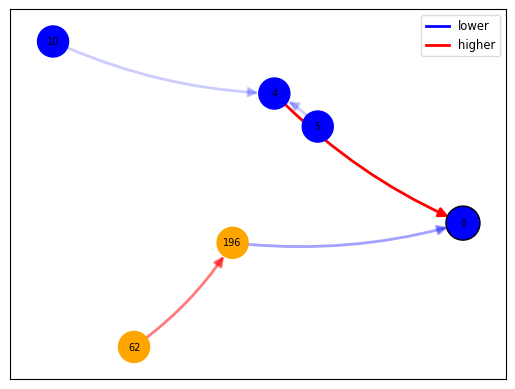

解释结果： <gnnshap.explanation.GNNShapExplanation object at 0x7f6e1a1558a0>


In [10]:
# 可视化解释结果
explanation.plot_graph()

# 检查 explanation 对象的所有属性
print("解释结果：", explanation)

In [11]:
print("解释结果的属性：", dir(explanation))

解释结果的属性： ['_GNNShapExplanation__get_edge_names', '_GNNShapExplanation__get_edge_names_series', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'base_value', 'computed_samples', 'fidelity_prob', 'fx', 'kwargs', 'node_idx', 'nplayers', 'nsamples', 'plot_bar', 'plot_force', 'plot_graph', 'result2dict', 'shap_values', 'sub_edge_index', 'sub_node_labels', 'sub_nodes', 'target_class', 'time_comp_graph', 'time_predictions', 'time_sampling', 'time_solver', 'time_total_comp']


In [1]:
explanation.plot_force(show_values=False)

NameError: name 'explanation' is not defined

In [1]:
import torch

In [6]:
torch.randn(3,3).to('cuda')

tensor([[ 0.9945, -1.3887, -0.3098],
        [-0.7294,  0.5590, -2.2451],
        [ 0.6969, -0.1875, -0.5499]], device='cuda:0')

In [7]:
torch.cuda.version

AttributeError: module 'torch.cuda' has no attribute 'version'